### Alternate agents each episode so that they can learn play on the left and right

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from base_agent import BaseAgent
from ddpg_agent import DDPGAgent
from environments import BaseEnvironment, OpenAiEnv, UnityEnv
from experiment import Experiment
from maddpg_agent import MIADDPG
from models import FC, FCDP, FCQV
from replay_buffer import ReplayBuffer
from strategy import NormalNoiseDecayStrategy
from plots import *

In [3]:
def create_miaddpg_agent(action_bounds, num_actions, num_states):
    actor = FCDP(num_states, action_bounds, (128, 128))
    critic = FCQV(num_states, num_actions, (128, 128))
    memory = ReplayBuffer(50000)
    train_strategy = NormalNoiseDecayStrategy(action_bounds, noise_start=.5, noise_decay=.995)
    agent = DDPGAgent(actor, critic, memory, train_strategy,
                      gamma=.99,
                      batch_size=256,
                      actor_lr=3e-4,
                      critic_lr=3e-4,
                      actor_max_grad_norm=float('inf'),
                      critic_max_grad_norm=float('inf'),
                      train_every_steps=1,
                      update_target_every_steps=1,
                      tau=.005)
    return agent

In [4]:
env = UnityEnv('Tennis_Linux_NoVis/Tennis.x86_64')
env.initialize(True)

num_states = env.state_shape[1]
num_agents = env.num_agents
num_actions = env.num_actions
action_bounds = (np.array([-1, -1]), np.array([1, 1]))

agents = [create_miaddpg_agent(action_bounds, num_actions, num_states) for i in range(num_agents)]
agent = MIADDPG(agents, alternate_agents=True)

Found path: /home/p.bazan/sources/courses_materials/playground/rl/udacity_p3/Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/home/p.bazan/sources/courses_materials/playground/rl/udacity_p3/Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/home/p.bazan/sources/courses_materials/playground/rl/udacity_p3/Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/p.bazan/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
exp = Experiment(env, agent, target_points=.5, stats_every_episode=10)

### Training

In [5]:
exp.train(10_000)

/home/p.bazan/miniconda3/envs/pdrl/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/p.bazan/miniconda3/envs/pdrl/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Episode: 2070, steps: 68, score: 0.20, avg_score: 0.52 agent ▶ avg_loss-0: -0.2 avg_policy_loss-0: -0.2 avg_value_loss-0: 0.0 train_iter-0: 71991 update_iter-0: 71991 memory_size-0: 50000 avg_loss-1: -0.2 avg_policy_loss-1: -0.2 avg_value_loss-1: 0.0 train_iter-1: 71991 update_iter-1: 71991 memory_size-1: 500000
Agent passed grading achieving min score:-0.01, mean score: 0.5


In [6]:
#exp.store('play1-alternate')
exp.load('play1-alternate')

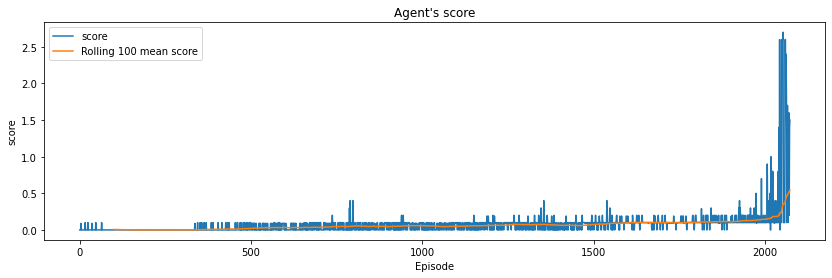

In [7]:
plot_experiment_stat(exp.history, 'score')
plt.savefig('play1_alternate_score.png', dpi=100)

In [1]:
plot_agent_stats(exp.history)
plt.savefig('play1_alternate_agent_stats.png', dpi=100)

NameError: name 'plot_agent_stats' is not defined

### Evalutation 

In [20]:
df = exp.evaluate(100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.56s/it]


In [21]:
df.describe()

,scores,moves_mse
count,100.00000,100.000000
mean,1.63950,0.868274
std,1.23396,0.113733
min,-0.00500,0.403207
25%,0.14500,0.841612
50%,2.60000,0.864878
75%,2.61250,0.882358
max,2.65000,1.403098


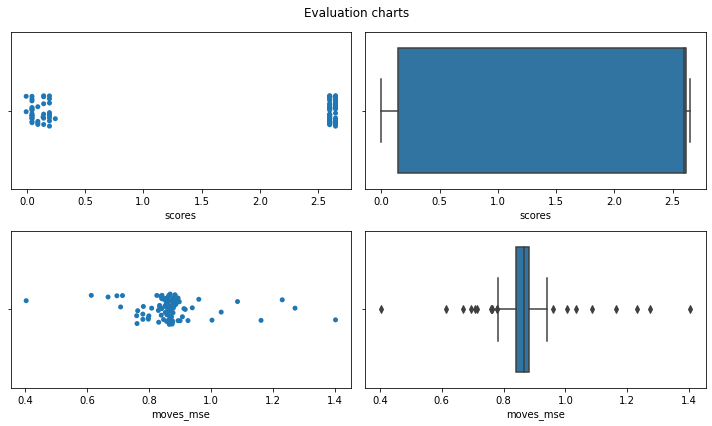

In [22]:
plot_evaluation_scores(df)
plt.savefig('play1_alternate_eval_scores.png', dpi=100)